In [1]:
%env HSA_OVERRIDE_GFX_VERSION=10.3.0
%env TF_FORCE_GPU_ALLOW_GROWTH=true
%env ROCM_PATH=/opt/rocm

import tensorflow as tf
tf.test.is_built_with_rocm()
# document export HSA_OVERRIDE_GFX_VERSION=10.3.0
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

env: HSA_OVERRIDE_GFX_VERSION=10.3.0
env: TF_FORCE_GPU_ALLOW_GROWTH=true
env: ROCM_PATH=/opt/rocm


2023-03-17 13:30:59.511418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 13:31:00.761396: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 13:31:00.761472: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 13:31:00.814088: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but th

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf


In [3]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices


In [4]:
def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")

In [5]:
def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(latent_inputs)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [6]:
def get_vqvae(latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(28, 28, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")


get_vqvae().summary()


2023-03-17 13:31:01.441598: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 13:31:01.442617: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 13:31:01.442781: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 13:31:01.442852: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but th

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 16)          19856     
                                                                 
 vector_quantizer (VectorQua  (None, 7, 7, 16)         1024      
 ntizer)                                                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         28033     
                                                                 
Total params: 48,913
Trainable params: 48,913
Non-trainable params: 0
_________________________________________________________________


In [7]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }


In [8]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)


In [9]:
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(x_train_scaled, epochs=30, batch_size=128)


2023-03-17 13:31:02.461244: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-17 13:31:02.461940: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-17 13:31:02.552602: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-17 13:31:02.553184: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


Epoch 1/30


2023-03-17 13:31:02.708832: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-17 13:31:02.710576: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-17 13:31:02.716839: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-17 13:31:02.717598: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-17 13:31:02.724265: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-17 13:31:02.725752: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-17 13:31:02.767021: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-17 13:31:02.768704: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-17 13:31:02.772672: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-17 13:31:02

469/469 [==============================] - 14s 21ms/step - loss: 2.0728 - reconstruction_loss: 0.3387 - vqvae_loss: 1.4122
Epoch 2/30
 10/469 [..............................] - ETA: 8s - loss: 2.2503 - reconstruction_loss: 0.1813 - vqvae_loss: 2.0683

2023-03-17 13:31:16.504682: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-17 13:31:16.505318: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-17 13:31:16.505827: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


469/469 [==============================] - 10s 21ms/step - loss: 1.8173 - reconstruction_loss: 0.1561 - vqvae_loss: 1.6491
Epoch 3/30
469/469 [==============================] - 10s 21ms/step - loss: 0.8738 - reconstruction_loss: 0.1227 - vqvae_loss: 0.7442
Epoch 4/30
469/469 [==============================] - 10s 21ms/step - loss: 0.5162 - reconstruction_loss: 0.1027 - vqvae_loss: 0.4097
Epoch 5/30
469/469 [==============================] - 10s 21ms/step - loss: 0.4002 - reconstruction_loss: 0.0874 - vqvae_loss: 0.3090
Epoch 6/30
469/469 [==============================] - 10s 21ms/step - loss: 0.3279 - reconstruction_loss: 0.0766 - vqvae_loss: 0.2493
Epoch 7/30
469/469 [==============================] - 10s 21ms/step - loss: 0.3007 - reconstruction_loss: 0.0715 - vqvae_loss: 0.2284
Epoch 8/30
469/469 [==============================] - 10s 21ms/step - loss: 0.2888 - reconstruction_loss: 0.0676 - vqvae_loss: 0.2203
Epoch 9/30
469/469 [==============================] - 10s 21ms/step - los


(eog:94553): Gtk-WARNING **: 13:50:33.157: Could not load a pixbuf from icon theme.
This may indicate that pixbuf loaders or the mime database could not be found.


1/1 [==============================] - 0s 14ms/step


2023-03-17 13:45:14.229297: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-17 13:45:14.245300: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-17 13:45:14.257351: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-17 13:45:14.262867: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-17 13:45:14.266162: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-03-17 13:45:14.269262: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


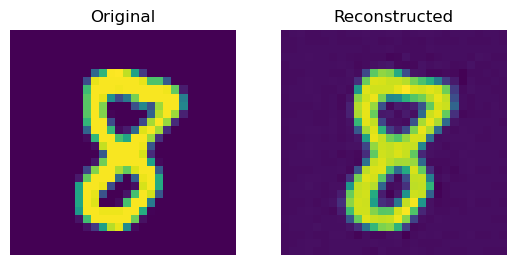

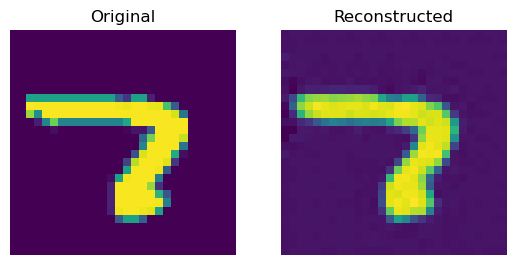

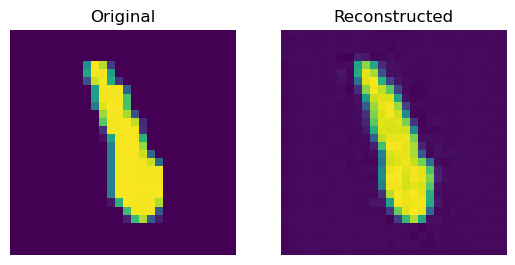

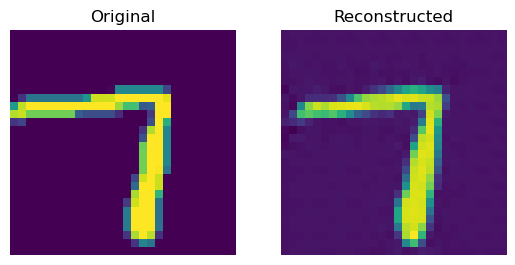

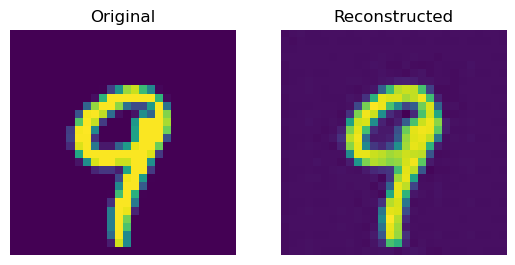

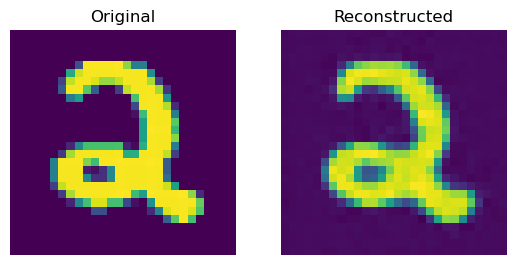

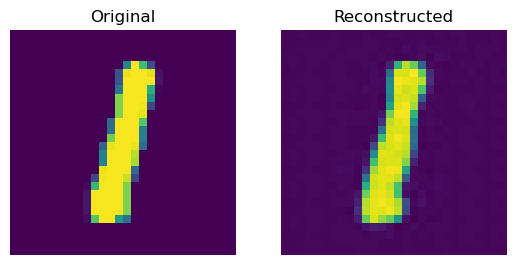

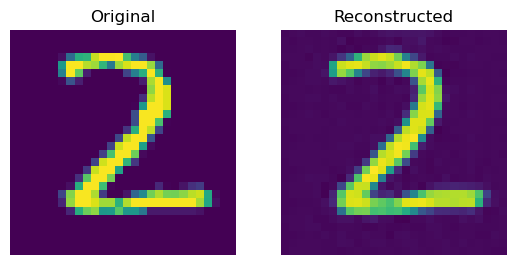

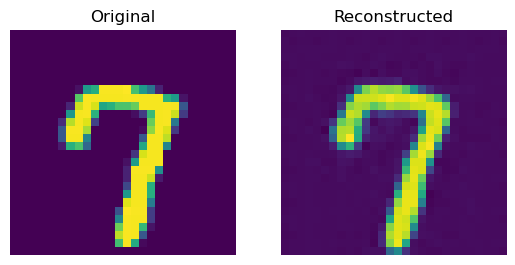

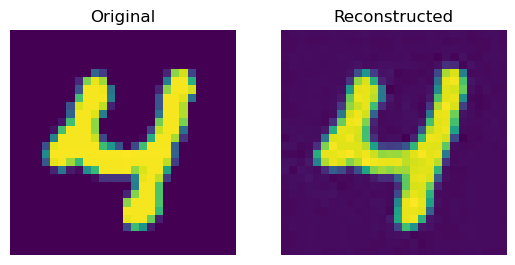

In [16]:
def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")
    
    plt.show()


trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)
